In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

In [2]:
names = ['wife age', 'wife education', 'husband education', 
         'No. of children ever born', 'wife religion', 'wife now working?', 
         'husband occupation', 'standard-of-living index', 'media exposure', 
         'contraceptive method choice']

In [3]:
cmc = pd.read_csv('cmc.data', header = None, names = names)
print(cmc.shape)                             
cmc.head()

(1473, 10)


,wife age,wife education,husband education,No. of children ever born,wife religion,wife now working?,husband occupation,standard-of-living index,media exposure,contraceptive method choice
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [10]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(cmc)

wife age 
 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49] 

wife education 
 [1 2 3 4] 

husband education 
 [1 2 3 4] 

No. of children ever born 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16] 

wife religion 
 [0 1] 

wife now working? 
 [0 1] 

husband occupation 
 [1 2 3 4] 

standard-of-living index 
 [1 2 3 4] 

media exposure 
 [0 1] 

contraceptive method choice 
 [1 2 3] 



In [16]:
def get_snapshot(df):
        n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
        pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
        dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
        n_unique = []
        for col in df.columns:
            n_unique.append(df[col].nunique())    
        return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = get_snapshot(cmc)
snapshot

,n_unique,dtype,n_missing,pct_missing
wife age,34,int64,0,0.0
wife education,4,int64,0,0.0
husband education,4,int64,0,0.0
No. of children ever born,15,int64,0,0.0
wife religion,2,int64,0,0.0
wife now working?,2,int64,0,0.0
husband occupation,4,int64,0,0.0
standard-of-living index,4,int64,0,0.0
media exposure,2,int64,0,0.0
contraceptive method choice,3,int64,0,0.0


In [17]:
np.sort(snapshot['n_unique'].unique())

array([ 2,  3,  4, 15, 34], dtype=int64)

In [25]:
num = ['No. of children ever born', 'wife age']

In [21]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    df[col].value_counts().plot.bar(color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

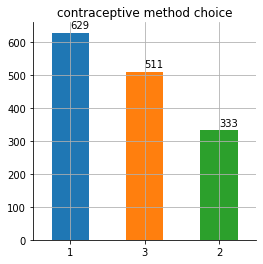

In [22]:
plot_single_categorical(cmc, 'contraceptive method choice')

In [14]:
cmc_dummi = pd.get_dummies(cmc, columns = ['contraceptive method choice', 'husband occupation'], dtype = int)

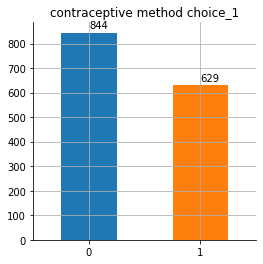

In [23]:
plot_single_categorical(cmc_dummi, 'contraceptive method choice_1')

In [19]:
targ_dummi = []
for col in cmc_dummi.columns:
    if col.startswith('contraceptive method choice'):
        targ_dummi.append(col)
        
features = cmc_dummi.columns.drop(targ_dummi)
features

Index(['wife age', 'wife education', 'husband education',
       'No. of children ever born', 'wife religion', 'wife now working?',
       'standard-of-living index', 'media exposure', 'husband occupation_1',
       'husband occupation_2', 'husband occupation_3', 'husband occupation_4'],
      dtype='object')

In [24]:
def feat_significance(X, y, n_feat_data_type, features):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in features:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [27]:
feat_score = feat_significance(cmc_dummi[features], cmc_dummi['contraceptive method choice_1'], 2, num)
feat_score

,score
No. of children ever born,0.064302
wife education,0.045993
husband occupation_2,0.022912
wife age,0.019952
husband education,0.018896
media exposure,0.015192
wife religion,0.014641
husband occupation_4,0.010039
standard-of-living index,0.009489
husband occupation_1,0.008426


In [28]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [29]:
get_mean_std(cmc_dummi[features])

,mean,std
wife age,32.538357,8.227245
wife education,2.958588,1.014994
husband education,3.429735,0.816349
No. of children ever born,3.261371,2.358549
wife religion,0.850645,0.356559
wife now working?,0.749491,0.433453
standard-of-living index,3.133741,0.976161
media exposure,0.073999,0.261858
husband occupation_1,0.295995,0.456644
husband occupation_2,0.288527,0.453231


In [30]:
X_scaled = pd.DataFrame(scale(cmc_dummi[features]), columns = features)
y = cmc_dummi['contraceptive method choice_1']

In [31]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [32]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

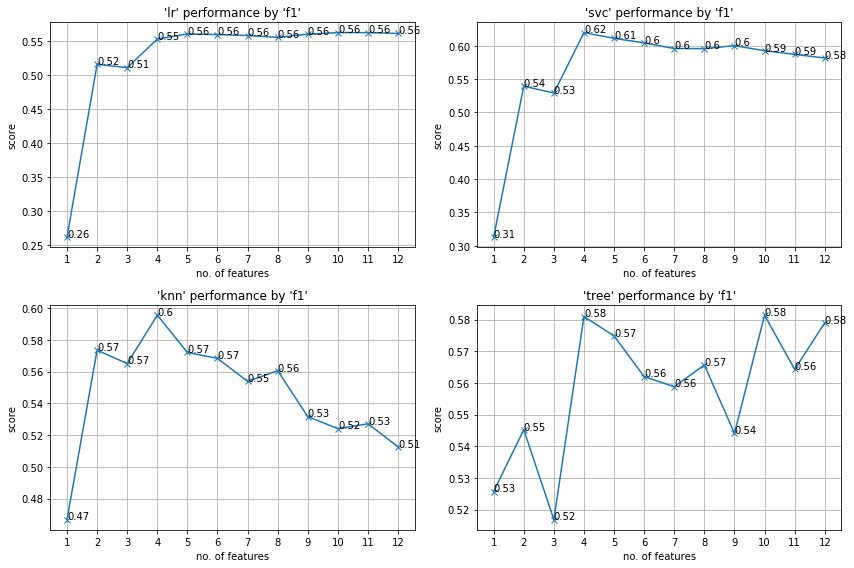

In [33]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled[feat_score.index], y, 'f1')

In [34]:
feat_svc = feat_score.index[0:4].drop(feat_score.index[2])
feat_svc

Index(['No. of children ever born', 'wife education', 'wife age'], dtype='object')

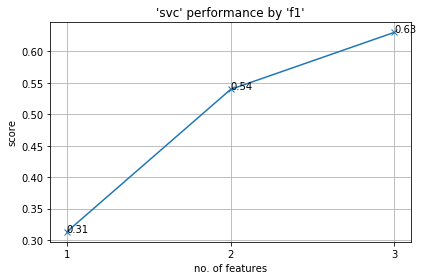

In [35]:
num_feat_multi_alg({svc: 'svc'}, feat_svc, X_scaled[feat_svc], y, 'f1')

In [36]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

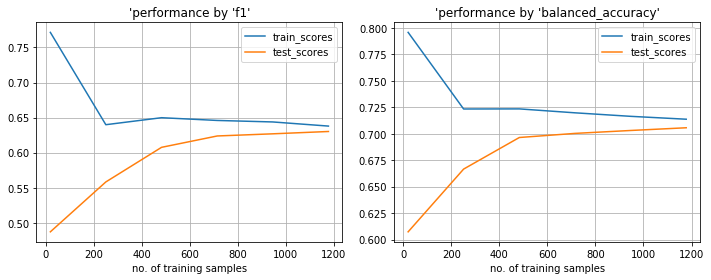

In [37]:
two_metric_graph(svc, X_scaled[feat_svc], y)

In [38]:
svc.fit(X_scaled[feat_svc], y)
joblib.dump(svc, 'svc.joblib')

['svc.joblib']